In [25]:
import mlflow
from mlflow.models import infer_signature

import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report, auc

In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

### Getting The Data Ready

In [3]:
df = pd.read_csv('../data/raw/raw_data.csv')

In [4]:
def preprocess(text):
    text = text.lower();
    text = re.sub('[+-]?((\d+\.?\d*)|(\.\d+))', 'number', text)
    text = re.sub('[$]+', 'dollar', text)
    return text;
def tokenize_and_stem(text):
    tokenizer = RegexpTokenizer(r'\w+')
    snow_stemmer = SnowballStemmer(language='english')
    
    words = tokenizer.tokenize(text)
    stemmed_words = []
    for w in words:
        if len(w) < 2:
            continue;
        stemmed_words.append(snow_stemmer.stem(w))
    
    return stemmed_words
def count_vec_analyzer(data):
    data =  preprocess(data)
    return tokenize_and_stem(data)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
corpus = df.text
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=count_vec_analyzer)),
    ('tfidf', TfidfTransformer())
])

pipeline.fit(corpus)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function count_vec_analyzer at 0x7fa421ce1260>)),
                ('tfidf', TfidfTransformer())])

In [8]:
corpus_tfidf = pipeline.transform(corpus)
transformed_df = pd.concat([df, pd.DataFrame(corpus_tfidf.toarray())], axis=1)
transformed_df.drop('text', axis=1, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split
train, remainder = train_test_split(transformed_df, train_size=0.8,stratify=transformed_df.spam)
validate, test = train_test_split(remainder, train_size=0.5, stratify=remainder.spam)

In [10]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [11]:
X_train = train.drop('spam', axis=1)
y_train = train.spam
X_validate = validate.drop('spam', axis=1)
y_validate = validate.spam
X_test = test.drop('spam', axis=1)
y_test = test.spam

In [53]:
import matplotlib.pyplot as plt
def print_aucpr(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)
    print("The AUCPR is - " + str(auc_pr))
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
        

### MultinomialNB

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
with mlflow.start_run() as run:
    
    params = {"alpha": 1, "fit_prior": True}
    model = MultinomialNB(**params)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_validate)
    signature = infer_signature(X_validate, y_validate)


    mlflow.log_params(params)
    mlflow.log_metrics({"mse": mean_squared_error(y_validate, y_pred)})


    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="Multinomial NB Model",
    )

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/aryan/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Multinomial NB Model'

### Support Vector Classifier

In [16]:
from sklearn.svm import SVC

In [17]:
with mlflow.start_run() as run:
    
    params = {"C": 1, "degree": 3, "gamma": "scale"}
    model = SVC(**params)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_validate)
    signature = infer_signature(X_validate, y_validate)


    mlflow.log_params(params)
    mlflow.log_metrics({"mse": mean_squared_error(y_validate, y_pred)})


    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="SVC",
    )

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'SVC'.
2024/02/20 12:35:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 1
Created version '1' of model 'SVC'.


### Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
with mlflow.start_run() as run:
    
    params = {"learning_rate": 0.1, "n_estimators": 100}
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_validate)
    signature = infer_signature(X_validate, y_validate)


    mlflow.log_params(params)
    mlflow.log_metrics({"mse": mean_squared_error(y_validate, y_pred)})


    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="GBC",
    )

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'GBC'.
2024/02/20 14:12:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GBC, version 1
Created version '1' of model 'GBC'.


### Loading MultinomialNB model

In [56]:
logged_model = 'runs:/942eda209a9c4efe899c8cf4d7cd2d7c/sklearn-model'
multinomial_nb = mlflow.pyfunc.load_model(logged_model)

In [57]:
y_pred = multinomial_nb.predict(X_test)

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/models/utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


The AUCPR is - 0.8000535025031528


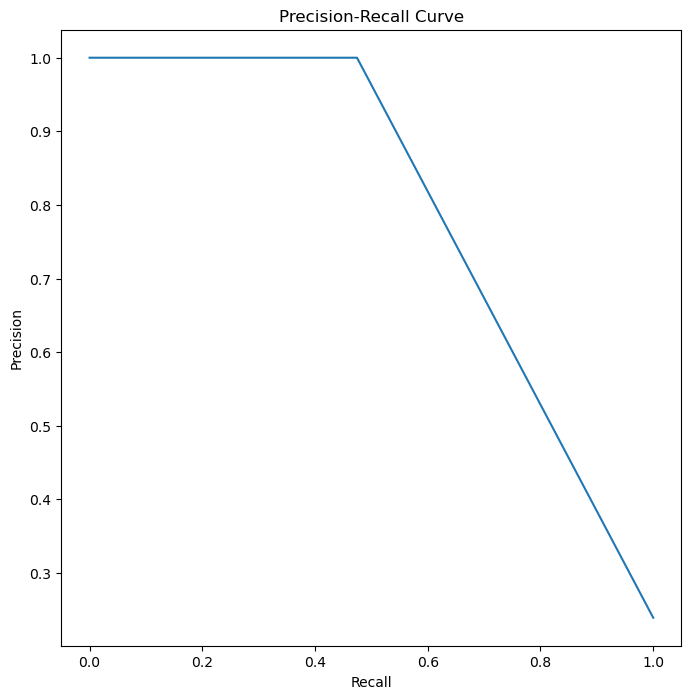

In [58]:
print_aucpr(y_test, y_pred)

### Loading SVC

In [59]:
logged_model = 'runs:/89adf893b9e5410380506a786cf822b8/sklearn-model'
svc = mlflow.pyfunc.load_model(logged_model)

In [60]:
y_pred = svc.predict(X_test)

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/models/utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


The AUCPR is - 0.9879651922339275


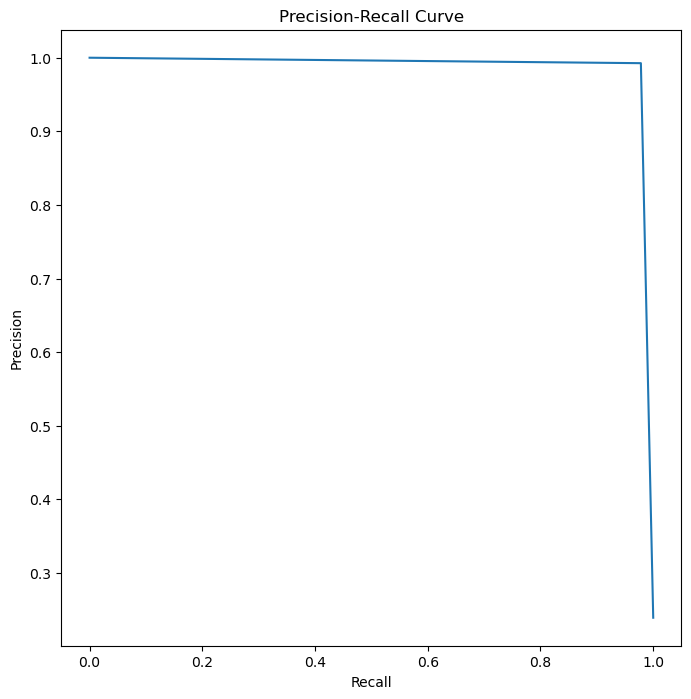

In [61]:
print_aucpr(y_test, y_pred)

### Loading Gradient Boosting Classifier

In [62]:
logged_model = 'runs:/caf14b987b8f4d529c490d8c8cfd9c8c/sklearn-model'
gbc = mlflow.pyfunc.load_model(logged_model)

In [63]:
y_pred = gbc.predict(X_test)

/home/aryan/anaconda3/lib/python3.11/site-packages/mlflow/models/utils.py:673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_pf_input[name] = _enforce_mlflow_datatype(name, pf_input[name], input_type)


The AUCPR is - 0.9482735490630693


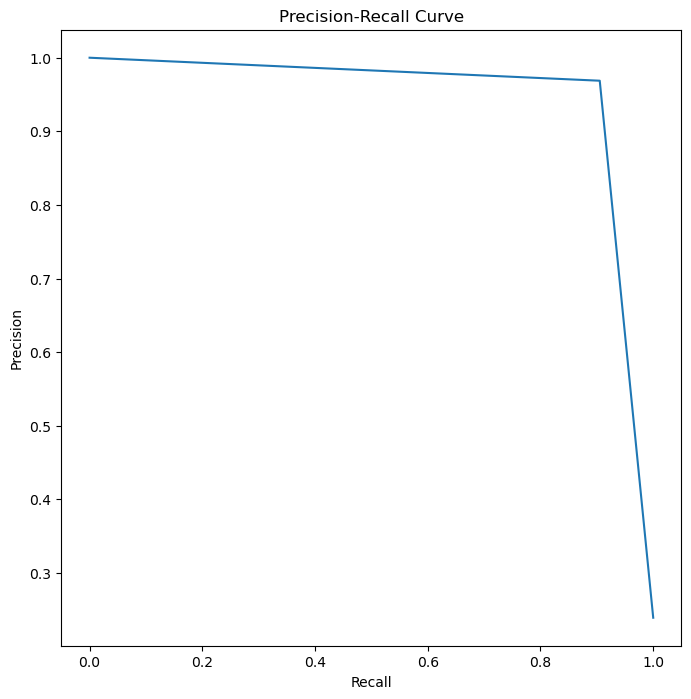

In [64]:
print_aucpr(y_test, y_pred)